In [1]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from scipy.optimize import curve_fit
realization = 1000
import seaborn as sns
from matplotlib import cm
from array_response import *
import itertools 

mat = io.loadmat('boundary.mat')
bound1_para = mat['bound1_para'][0,:]
bound2_para = mat['bound2_para'][0,:]
bound3_para = mat['bound3_para'][0,:]
bound4_1para = mat['bound4_1para'][0,:]
bound4_2para = mat['bound4_2para'][0,:]

bound4_3para = mat['bound4_3para'][0,:]
xlim_4_1 = mat['xlim_4_1'][0,0]
xlim_4_2 = mat['xlim_4_2'][0,:]
xlim_4_3 = mat['xlim_4_3'][0,0]


In [2]:
azi_rot = np.linspace(0,2*np.pi,50)

In [3]:
def func_sin(x, c, d):
    return np.sin(2*np.pi*x*0.312 + c)*0.23 + d

In [4]:
test_1 = func_sin(azi_rot, *bound1_para)
test_2 = func_sin(azi_rot, *bound2_para)
bound3 = np.poly1d(bound3_para)
boud4_13 = np.poly1d(bound4_1para)
bound4_2 = np.poly1d(bound4_2para)

(0, 3.14)

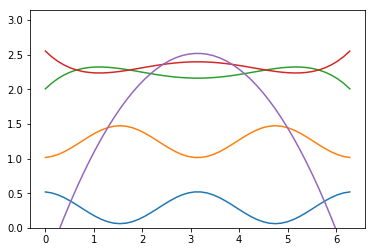

In [5]:
plt.plot(azi_rot,test_1)
plt.plot(azi_rot,test_2)
plt.plot(azi_rot,bound3(azi_rot))
plt.plot(azi_rot,boud4_13(azi_rot))
plt.plot(azi_rot,bound4_2(azi_rot))
plt.ylim(0,3.14)

In [6]:
def check_cate(_azi,_ele):
    _index = ""
    if ((_ele - bound3(_azi)) > 0):
        if (((_azi<xlim_4_1) and ((_ele - boud4_13(_azi))<0)) or ((_azi>xlim_4_2[0]) and (_azi<xlim_4_2[1]) and ((_ele - bound4_2(_azi))<0)) or ((_azi>xlim_4_3) and ((_ele - boud4_13(_azi))<0))):
            _index = "samecluster"
        else:
            _index = "diffclus_samepol"
    else:
        if ((_ele - func_sin(_azi, *bound2_para)) > 0):
            _index = "diffclus_crosspol"
        else:
            if ((_ele - func_sin(_azi, *bound1_para)) > 0):
                _index = "samecluster"
            else:
                _index = "diffclus_samepol"
            
    return _index

### Parameters declaration

Declare parameters needed for channel realization

In [7]:
Ns = 1 # number of streams

Nc = 6 # number of cluster
Nray = 1 # number of rays in each cluster

Nt = 64 # number of transmit antennas
Nr = 16 # number of receive antennas

angle_sigma = 10/180*np.pi # standard deviation of the angles in azimuth and elevation both of Rx and Tx

gamma = np.sqrt((Nt*Nr)/(Nc*Nray))
realization = 1000 # equivalent to number of taking sample
count = 0

eps = 0.1 # 20dB isolation
sigma = np.sqrt(8/(1+eps**2))*1.37/1.14 # according to the normalization condition of H

### Channel Realization

Realize channel H for Dual-Polarized antenna array

In [8]:
H_pol = np.zeros((2*Nr,2*Nt,realization),dtype=complex)
At = np.zeros((Nt,Nc*Nray,realization),dtype=complex)
Ar = np.zeros((Nr,Nc*Nray,realization),dtype=complex)
alpha_hh = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_hv = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_vh = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_vv = np.zeros((Nc*Nray,realization),dtype=complex)

AoD = np.zeros((2,Nc*Nray),dtype=complex)
AoA = np.zeros((2,Nc*Nray),dtype=complex)

H = np.zeros((2*Nr,2*Nt,realization),dtype=complex)
azi_rot = np.random.normal(1.7,0.3,realization)
ele_rot = np.random.normal(2.3,0.3,realization) # Why PI/2 ??
# azi_rot = np.random.uniform(0,2*np.pi,realization)
# ele_rot = np.random.uniform(0,np.pi,realization) # Why PI/2 ??
R = np.array([[np.cos(ele_rot)*np.cos(azi_rot),np.sin(ele_rot)],[-np.sin(ele_rot)*np.cos(azi_rot),np.cos(ele_rot)]]) # rotation matrix

for reali in range(realization):
    for c in range(1,Nc+1):
        AoD_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Departure _ azimuth
        AoD_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Departure _ elevation
        AoA_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Arrival_ azimuth
        AoA_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Arrival_ elevation
        AoD[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_azi_m, angle_sigma, (1,Nray))
        AoD[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_ele_m, angle_sigma, (1,Nray))
        AoA[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_azi_m, angle_sigma, (1,Nray))
        AoA[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_ele_m, angle_sigma, (1,Nray))
    for j in range(Nc*Nray):
        At[:,j,reali] = array_response(AoD[0,j],AoD[1,j],Nt) # UPA array response
        Ar[:,j,reali] = array_response(AoA[0,j],AoA[1,j],Nr)
        var_hh = ((sigma**2)*(np.cos(AoD[0,j])**2)*(np.cos(AoA[0,j])**2)).real
        var_hv = ((eps**2)*(sigma**2)*(np.cos(AoD[1,j])**2)*(np.cos(AoA[0,j])**2)).real
        var_vh = ((eps**2)*(sigma**2)*(np.cos(AoD[0,j])**2)*(np.cos(AoA[1,j])**2)).real
        var_vv = ((sigma**2)*(np.cos(AoD[1,j])**2)*(np.cos(AoA[1,j])**2)).real
        alpha_hh[j,reali] = np.random.normal(0, np.sqrt(var_hh/2)) + 1j*np.random.normal(0, np.sqrt(var_hh/2))
        alpha_hv[j,reali] = np.random.normal(0, np.sqrt(var_hv/2)) + 1j*np.random.normal(0, np.sqrt(var_hv/2))
        alpha_vh[j,reali] = np.random.normal(0, np.sqrt(var_vh/2)) + 1j*np.random.normal(0, np.sqrt(var_vh/2))
        alpha_vv[j,reali] = np.random.normal(0, np.sqrt(var_vv/2)) + 1j*np.random.normal(0, np.sqrt(var_vv/2))
        alpha = np.vstack((np.hstack((alpha_hh[j,reali],alpha_hv[j,reali])),np.hstack((alpha_vh[j,reali],alpha_vv[j,reali]))))
        H_pol[:,:,reali] = H_pol[:,:,reali] + np.kron(alpha,Ar[:,[j],reali]@At[:,[j],reali].conj().T)
    H_pol[:,:,reali] = gamma* H_pol[:,:,reali]
    H[:,:,reali] = (np.kron(R[:,:,reali],np.eye(Nr)))@H_pol[:,:,reali]
    H[:,:,reali] = np.sqrt(4/3)* H[:,:,reali]

### Check normalized condition

In [9]:
channel_fro_2 = np.zeros(realization)
for reali in range(realization):
    channel_fro_2[reali] = np.linalg.norm(H[:,:,reali],'fro')
print("4*Nt*Nr =", 4*Nt*Nr , "   Frobenius norm =", np.mean(channel_fro_2**2))

4*Nt*Nr = 4096    Frobenius norm = 4262.101209641846


In [10]:
cluster = np.arange(Nc)
print(cluster)
c = list(itertools.combinations(cluster, 2))
num_path = (2*Nc-1)*Nc
path_combi = np.zeros((num_path,4),dtype=int)

print(path_combi.shape)
path_combi[0:Nc,:]=np.arange(Nc).reshape(Nc,1).repeat(4,axis=1)

count = 0
for i in range(int(Nc*(Nc-1)/2)):
    path_combi[Nc+4*i,:] = np.array([c[count][0],c[count][0],c[count][1],c[count][1]])
    path_combi[Nc+4*i+1,:] = np.array([c[count][1],c[count][1],c[count][0],c[count][0]])
    path_combi[Nc+4*i+2,:] = np.array([c[count][0],c[count][1],c[count][1],c[count][0]])
    path_combi[Nc+4*i+3,:] = np.array([c[count][1],c[count][0],c[count][0],c[count][1]])
    count = count+1

[0 1 2 3 4 5]
(66, 4)


In [11]:
cross_index =  []
samepolar_index = []
count = Nc-1
while (count<num_path-4):
    cross_index.extend([count+3,count+4])
    samepolar_index.extend([count+1,count+2])
    count = count + 4
cross_index = np.array(cross_index)
samepolar_index = np.array(samepolar_index)
sameclus_index = np.arange(0,Nc)
print(cross_index)
print(samepolar_index)
print(sameclus_index)
# print(path_combi)

[ 8  9 12 13 16 17 20 21 24 25 28 29 32 33 36 37 40 41 44 45 48 49 52 53
 56 57 60 61 64 65]
[ 6  7 10 11 14 15 18 19 22 23 26 27 30 31 34 35 38 39 42 43 46 47 50 51
 54 55 58 59 62 63]
[0 1 2 3 4 5]


In [12]:
path_gain = np.zeros((num_path,realization)) # 2 to save the position and maximum value
for reali in range(realization):
    for combi in range(num_path):
        path_gain[combi,reali] =\
        (np.abs\
         ((np.cos(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hh[path_combi[combi,0],reali]+np.sin(ele_rot[reali])*alpha_vh[path_combi[combi,0],reali])*(path_combi[combi,0]==path_combi[combi,1])+\
         (np.cos(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hv[path_combi[combi,2],reali]+np.sin(ele_rot[reali])*alpha_vv[path_combi[combi,2],reali])*(path_combi[combi,2]==path_combi[combi,1])+\
         (-np.sin(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hh[path_combi[combi,0],reali]+np.cos(ele_rot[reali])*alpha_vh[path_combi[combi,0],reali])*(path_combi[combi,0]==path_combi[combi,3])+\
         (-np.sin(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hv[path_combi[combi,2],reali]+np.cos(ele_rot[reali])*alpha_vv[path_combi[combi,2],reali])*(path_combi[combi,2]==path_combi[combi,3])
         ))**2


In [13]:
print(np.max(path_gain[0:Nc,2]))
print(path_gain[0:Nc,2])

print(path_gain[samepolar_index,2])
print(np.max(path_gain[samepolar_index,2]))

3.5124435378739203
[0.01737014 1.1288581  3.51244354 0.00552094 0.04258435 0.02924791]
[2.09779097e-02 8.52181462e-02 8.97629209e-02 8.65206991e-02
 1.77311234e-03 5.16087577e-03 3.10323606e-03 4.31968639e-02
 1.16448540e-03 1.97209357e-04 2.96058001e-01 5.25338874e-02
 9.05755845e-02 5.46114510e-02 8.61826718e-02 1.28917351e-01
 8.59850591e-02 2.91657500e-02 8.37641707e-02 1.50847577e-01
 9.01275743e-02 2.59708172e-01 8.70407459e-02 1.05866494e-01
 2.50002064e-03 3.25049896e-02 3.60995214e-03 2.65390726e-04
 3.56007225e-02 8.23835531e-04]
0.29605800108223035


__Check maximum gain from combination of path in each realization__

In [14]:
index = np.zeros(realization,dtype=int)
for reali in range(realization):
    index[reali] = np.argmax(path_gain[:,reali])

__Same Cluster__

In [15]:
index_sameclus = np.zeros(realization,dtype=int)
for reali in range(realization):
    index_sameclus[reali] = np.argmax(path_gain[0:Nc,reali])

In [16]:
gain_sameclus = np.zeros(realization,dtype=float)
for reali in range(realization):
    gain_sameclus[reali] = path_gain[index_sameclus[reali],reali]

__Chosen Category before check__

In [17]:
choosen_cate = ["" for x in range(realization)]

index_checkcate = np.zeros(realization,dtype=int)
cate = ""
temp = 0
for reali in range(realization):
    cate = check_cate(azi_rot[reali],ele_rot[reali])
    if (cate == "samecluster"):
        index_checkcate[reali] = np.argmax(path_gain[0:Nc,reali])
    if (cate == "diffclus_samepol"):
        temp = np.argmax(path_gain[samepolar_index,reali])
        index_checkcate[reali] = int(temp+(np.floor(temp/2))*2+Nc)
#         index_checkcate[reali] = np.argmax(path_gain[samepolar_index,reali])
    if (cate == "diffclus_crosspol"):
#         index_checkcate[reali] = np.argmax(path_gain[cross_index,reali])
        temp = np.argmax(path_gain[cross_index,reali])
        index_checkcate[reali] = int(temp+(np.floor(temp/2)+1)*2+Nc) 
    choosen_cate[reali] = cate
    temp = 0


### Plot Spectral Efficiency

In [18]:
SNR_dB = np.arange(-35,10,5)
SNR = 10**(SNR_dB/10)
smax = SNR.shape[0]
R_cross = np.zeros([smax, realization],dtype=complex)
# R_steer = np.zeros([smax, realization],dtype=complex)
R_samecl = np.zeros([smax, realization],dtype=complex)
R_checkcate = np.zeros([smax, realization],dtype=complex)

for reali in range(realization):
    _chosen_combi_path = path_combi[index[reali]]
    _chosen_checkcate_path = path_combi[index_checkcate[reali]]
#     _chosen_checkcate_path = path_combi[:,reali]
    _chosen_sameclus_path = path_combi[index_sameclus[reali]]
    
    W_cross = np.vstack((Ar[:,[_chosen_combi_path[1]],reali],Ar[:,[_chosen_combi_path[3]],reali]))
    F_cross = np.vstack((At[:,[_chosen_combi_path[0]],reali],At[:,[_chosen_combi_path[2]],reali]))
    
    W_checkcate = np.vstack((Ar[:,[_chosen_checkcate_path[1]],reali],Ar[:,[_chosen_checkcate_path[3]],reali]))
    F_checkcate = np.vstack((At[:,[_chosen_checkcate_path[0]],reali],At[:,[_chosen_checkcate_path[2]],reali]))
#     W_steer = np.vstack((Ar[:,[_chosen_steer_path[0]],reali],Ar[:,[_chosen_steer_path[1]],reali]))
#     F_steer = np.vstack((At[:,[_chosen_steer_path[0]],reali],At[:,[_chosen_steer_path[1]],reali]))
    
    W_samecl = np.vstack((Ar[:,[_chosen_sameclus_path[1]],reali],Ar[:,[_chosen_sameclus_path[3]],reali]))
    F_samecl = np.vstack((At[:,[_chosen_sameclus_path[0]],reali],At[:,[_chosen_sameclus_path[2]],reali]))
    for s in range(smax):
        R_cross[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+(SNR[s]/Ns)*np.linalg.pinv(W_cross)@H[:,:,reali]@F_cross@F_cross.conj().T@H[:,:,reali].conj().T@W_cross))
        R_checkcate[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+(SNR[s]/Ns)*np.linalg.pinv(W_checkcate)@H[:,:,reali]@F_checkcate@F_checkcate.conj().T@H[:,:,reali].conj().T@W_checkcate))
        R_samecl[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+(SNR[s]/Ns)*np.linalg.pinv(W_samecl)@H[:,:,reali]@F_samecl@F_samecl.conj().T@H[:,:,reali].conj().T@W_samecl))

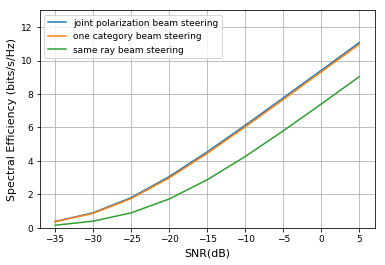

In [25]:
plt.plot(SNR_dB, (np.sum(R_cross,axis=1).real)/realization, label='joint polarization beam steering')
plt.plot(SNR_dB, (np.sum(R_checkcate,axis=1).real)/realization, label='one category beam steering')
plt.plot(SNR_dB, (np.sum(R_samecl,axis=1).real)/realization, label='same ray beam steering')

plt.legend(loc='upper left',prop={'size': 9})
plt.xlabel('SNR(dB)',fontsize=11)
plt.ylabel('Spectral Efficiency (bits/s/Hz)',fontsize=11)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.ylim(0,13)
plt.grid()
plt.show()